In [17]:
import antiCPy
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import seaborn as sns
sns.set()

In [18]:
XAI = np.load("XAI_Finance.npy")
Names = np.load("Names.npy")
CorrMatrices = np.load("CorrMatricesTriangular.npy")
LabelNaiveOrdered = np.load("LabelNaiveOrdered.npy")
#OptimalXAI = np.load("OptimalXAIFeature.npy")
# now something different
OptimalXAI = np.load("XAI_modes.npy")
MedianLogical = np.load("MedianLogical.npy")
print(OptimalXAI, MedianLogical)
print(CorrMatrices[:, MedianLogical].shape)

[[ 0 11]
 [ 1 40]
 [ 2 37]
 [ 3 41]
 [ 4 16]
 [ 5 16]
 [ 6 14]
 [ 7 16]] [False False False False False False False False False False False False
 False False  True  True  True False False False False False False  True
 False False False False False False  True False False False False False
 False False False False False  True False False False False False False
 False False False False False False False]
(5251, 6)


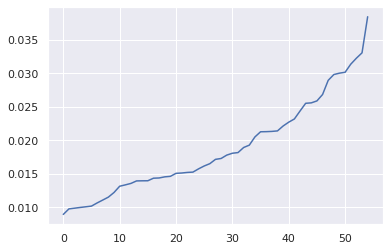

In [19]:
#plt.plot(np.sort(abs(XAI).mean(0)))
plt.plot(np.sort(np.median(abs(XAI),0)))

### Train NN with all relevant features

For this, we need one-hot encoded y

In [20]:
print(set(OptimalXAI[:,1]))
CM_Reduced = CorrMatrices[:,list(set(OptimalXAI[:,1]))]
print(CM_Reduced.shape)

# one hot encoded
encoded_Y = np_utils.to_categorical(LabelNaiveOrdered)

X_train, X_test, y_train, y_test = train_test_split(CM_Reduced, encoded_Y,
                                                    test_size=0.33, random_state=1)
print(encoded_Y)

# reverse the encoding via
# np.argmax(encoded_Y, 1)

{37, 40, 41, 11, 14, 16}
(5251, 6)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


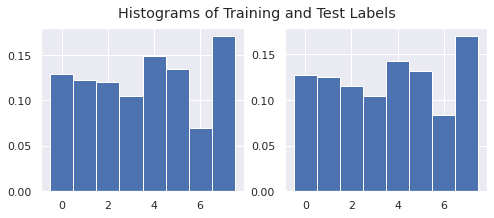

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(8, 3)
ax1.hist(np.argmax(y_train,1), density = True,
         bins = np.arange(-0.5, max(np.argmax(y_train,1))+1.5,1))
ax2.hist(np.argmax(y_test,1),density = True,
         bins = np.arange(-0.5, max(np.argmax(y_test,1))+1.5,1))
plt.suptitle("Histograms of Training and Test Labels")
plt.show()

In [22]:
n_In = CM_Reduced.shape[1]
num_classes = len(set(LabelNaiveOrdered))
print(n_In, num_classes)

model = keras.Sequential(
    [
        layers.Dense(units = 256, input_shape=(n_In,), activation = "selu"),
        layers.Dense(units=128, activation="relu"),
        layers.Dense(units=128, activation="relu"),
        layers.Dense(units=1024,
              activation=keras.layers.LeakyReLU(alpha=0.05)),
        layers.Dense(units=128,
              activation=keras.layers.LeakyReLU(alpha=0.01)),
        layers.Dropout(0.3),
        layers.Dense(units =num_classes, activation="softmax"),
    ]
)
#model.build(n_In)
model.summary()

6 8
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               1792      
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dense_9 (Dense)             (None, 1024)              132096    
                                                                 
 dense_10 (Dense)            (None, 128)               131200    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 8)            

In [23]:
batch_size = 128
epochs = 100

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(lr=0.0001),
              metrics=["accuracy"])

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.5)

Epoch 1/100
14/14 [==============================] - 0s 11ms/step - loss: 2.0415 - accuracy: 0.2399 - val_loss: 2.0134 - val_accuracy: 0.2331
Epoch 2/100
14/14 [==============================] - 0s 5ms/step - loss: 1.9671 - accuracy: 0.2763 - val_loss: 1.9444 - val_accuracy: 0.2609
Epoch 3/100
14/14 [==============================] - 0s 5ms/step - loss: 1.8771 - accuracy: 0.3189 - val_loss: 1.8524 - val_accuracy: 0.3309
Epoch 4/100
14/14 [==============================] - 0s 5ms/step - loss: 1.7646 - accuracy: 0.3889 - val_loss: 1.7236 - val_accuracy: 0.4190
Epoch 5/100
14/14 [==============================] - 0s 5ms/step - loss: 1.6111 - accuracy: 0.4974 - val_loss: 1.5613 - val_accuracy: 0.5026
Epoch 6/100
14/14 [==============================] - 0s 4ms/step - loss: 1.4449 - accuracy: 0.5486 - val_loss: 1.3860 - val_accuracy: 0.5497
Epoch 7/100
14/14 [==============================] - 0s 4ms/step - loss: 1.2912 - accuracy: 0.5776 - val_loss: 1.2341 - val_accuracy: 0.5782
Epoch 8/100


In [24]:
y_hat = np.argmax(model.predict(X_test),1)
Accuracy_BestXAI = np.mean(y_hat == np.argmax(y_test,1))
print(Accuracy_BestXAI)

0.7864974033467974


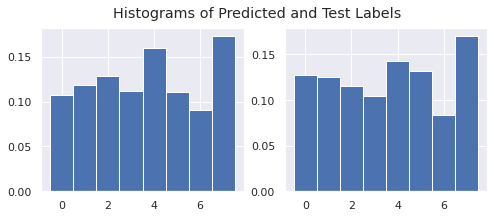

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(8, 3)
ax1.hist(y_hat, density = True,
         bins = np.arange(-0.5, max(y_hat)+1.5,1))
ax2.hist(np.argmax(y_test,1),density = True,
         bins = np.arange(-0.5, max(np.argmax(y_test,1))+1.5,1))
plt.suptitle("Histograms of Predicted and Test Labels")
plt.show()

### Comparison: best features according to Median XAI values

In [26]:


X_train, X_test, y_train, y_test = train_test_split(CorrMatrices[:, MedianLogical],
                                                    encoded_Y, test_size=0.33, random_state=1)


model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.5)

y_hat = np.argmax(model.predict(X_test),1)
Accuracy_BestMedianXAI = np.mean(y_hat == np.argmax(y_test,1))


Epoch 1/100
14/14 [==============================] - 0s 5ms/step - loss: 2.8343 - accuracy: 0.3422 - val_loss: 1.8374 - val_accuracy: 0.3530
Epoch 2/100
14/14 [==============================] - 0s 4ms/step - loss: 1.5275 - accuracy: 0.4508 - val_loss: 1.2986 - val_accuracy: 0.4923
Epoch 3/100
14/14 [==============================] - 0s 4ms/step - loss: 1.1866 - accuracy: 0.5429 - val_loss: 1.1217 - val_accuracy: 0.5657
Epoch 4/100
14/14 [==============================] - 0s 5ms/step - loss: 1.0428 - accuracy: 0.6163 - val_loss: 1.0269 - val_accuracy: 0.6140
Epoch 5/100
14/14 [==============================] - 0s 5ms/step - loss: 0.9695 - accuracy: 0.6498 - val_loss: 0.9692 - val_accuracy: 0.6339
Epoch 6/100
14/14 [==============================] - 0s 5ms/step - loss: 0.9092 - accuracy: 0.6646 - val_loss: 0.9253 - val_accuracy: 0.6430
Epoch 7/100
14/14 [==============================] - 0s 4ms/step - loss: 0.8833 - accuracy: 0.6737 - val_loss: 0.8988 - val_accuracy: 0.6583
Epoch 8/100
1

In [27]:
print(Accuracy_BestMedianXAI)

0.7997691863819966


### Now with some other features

In [28]:
def TestNN(seed = 1234):
    np.random.seed(seed)
    Index = np.random.choice(np.arange(XAI.shape[1]).astype("int"), # features to compare optimal XAI to
                     size = len(list(set(OptimalXAI[:,1]))),
                     replace = False)
    CM_Reduced = CorrMatrices[:,Index]
    X_train, X_test, y_train, y_test = train_test_split(CM_Reduced, encoded_Y,
                                                    test_size=0.33, random_state=1)
    model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.5,
          verbose=0)
    y_hat = np.argmax(model.predict(X_test),1)
    return(np.mean(y_hat == np.argmax(y_test,1)))

In [29]:
def ModeModeNN(seed = 1234):
    np.random.seed(seed)
    CM_Reduced = CorrMatrices[:,list(set(OptimalXAI[:,1]))]
    X_train, X_test, y_train, y_test = train_test_split(CM_Reduced, encoded_Y,
                                                    test_size=0.33, random_state=1)
    model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.5,
          verbose=0)
    y_hat = np.argmax(model.predict(X_test),1)
    return(np.mean(y_hat == np.argmax(y_test,1)))

In [30]:
def MedianNN(seed = 1234):
    np.random.seed(seed)
    CM_Reduced = CorrMatrices[:, MedianLogical]
    X_train, X_test, y_train, y_test = train_test_split(CM_Reduced, encoded_Y,
                                                    test_size=0.33, random_state=1)
    model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.5,
          verbose=0)
    y_hat = np.argmax(model.predict(X_test),1)
    return(np.mean(y_hat == np.argmax(y_test,1)))

In [31]:
ModeModeNN(53473)

0.8147720715522215

In [32]:
MedianNN(23757)

0.8430467397576457

In [33]:
TestNN(54321)

0.7559145989613387

In [34]:
TestNN()

0.7651471436814772

In [35]:
Runs = 100
NN_comparison = np.zeros(Runs)
NN_modemode = np.zeros(Runs)
NN_median = np.zeros(Runs)

for i in range(Runs):
    s = np.random.choice(np.arange(10000).astype("int"),1)
    Test_Score = TestNN(s)
    Mode_Score = ModeModeNN(s)
    Median_Score = MedianNN(s)
    print(i,s,Test_Score,Mode_Score, Median_Score)
    NN_comparison[i] = Test_Score
    NN_modemode[i] = Mode_Score
    NN_median[i] = Median_Score


0 [5206] 0.7836122331217542 0.8205424120023082 0.8586266589728794
1 [1145] 0.7247547605308713 0.8430467397576457 0.8649740334679746
2 [1896] 0.6982111944604732 0.8597807270628968 0.8678592036930178
3 [5294] 0.7726485862665897 0.860934795152914 0.875937680323139
4 [1182] 0.8101557991921523 0.8690132717830352 0.8736295441431045
5 [6053] 0.8032313906520485 0.8661281015579919 0.8707443739180611
6 [8396] 0.7818811309867282 0.8695903058280439 0.8736295441431045
7 [9755] 0.7449509521061742 0.8597807270628968 0.875937680323139
8 [4313] 0.7934218118869013 0.8655510675129833 0.8742065781881131
9 [4630] 0.790536641661858 0.8695903058280439 0.8678592036930178
10 [9956] 0.8147720715522215 0.8672821696480092 0.8684362377380266
11 [580] 0.7686093479515291 0.879399884593191 0.8770917484131564
12 [3794] 0.8078476630121177 0.8753606462781304 0.8678592036930178
13 [8910] 0.7484131563762262 0.8845931909982689 0.8684362377380266
14 [7098] 0.7651471436814772 0.8840161569532602 0.8667051356030006
15 [7039] 0

In [49]:
len(NN_modemode), len(NN_comparison), len(NN_median)

(100, 100, 100)

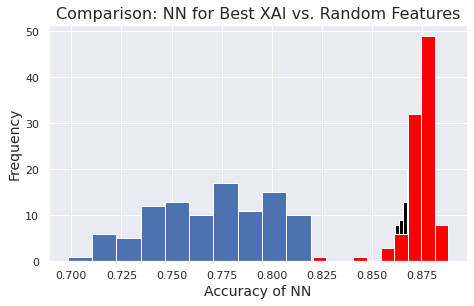

In [51]:
fig = plt.gcf()
fig.set_size_inches(7.5,4.35)
plt.hist(NN_comparison)
plt.hist(NN_median, color="black")
plt.hist(NN_modemode, color="red", bins=10)
#plt.axvline(Accuracy_BestXAI, c="red")
#plt.axvline(Accuracy_BestMedianXAI,  c="black")
plt.xlabel("Accuracy of NN",fontsize=14)
plt.ylabel("Frequency",fontsize=14)
plt.title("Comparison: NN for Best XAI vs. Random Features",
          fontsize = 16)
#plt.savefig("Comparison_RandomFeatures_vs_XAImode_100NNs",dpi=600)
plt.show()

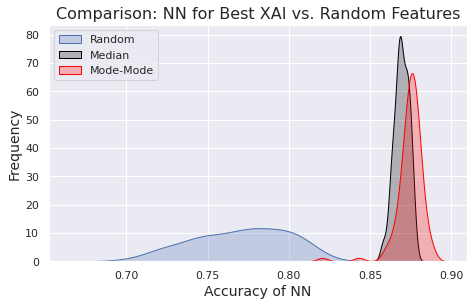

In [61]:
fig = plt.gcf()
fig.set_size_inches(7.5,4.35)
sns.kdeplot(NN_comparison, label ="Random", fill=True)
sns.kdeplot(NN_median, color = "black", label="Median",fill=True)
sns.kdeplot(NN_modemode, color = "red", label="Mode-Mode",fill=True)
plt.legend(loc="upper left")
plt.xlabel("Accuracy of NN",fontsize=14)
plt.ylabel("Frequency",fontsize=14)
plt.title("Comparison: NN for Best XAI vs. Random Features",
          fontsize = 16)
plt.savefig("Comparison_100NNs_kde.pdf",dpi=600)
plt.show()

In [58]:
print(np.mean(NN_median), np.std(NN_median),np.mean(NN_median)+ np.std(NN_median) )
print(np.mean(NN_modemode), np.std(NN_modemode),np.mean(NN_modemode)- np.std(NN_modemode) )


0.8691863819965377 0.004478245197891232 0.8736646271944289
0.874212348528563 0.00828862556718412 0.8659237229613789


In [64]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               1792      
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dense_9 (Dense)             (None, 1024)              132096    
                                                                 
 dense_10 (Dense)            (None, 128)               131200    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 8)                